# AG News - Error Analysis & Insights

**Task**: Single-label News Topic Classification  
**Objective**: Deep dive into model errors and qualitative analysis  

---

## Pipeline Overview

1. Environment Setup
2. Load Models & Predictions
3. Error Pattern Analysis
4. Confidence Analysis
5. Difficult Sample Identification
6. Cross-Model Agreement Analysis
7. Qualitative Error Examples
8. Insights & Recommendations

## 1. Environment Setup

In [1]:
!pip install -q transformers datasets accelerate evaluate scikit-learn
!pip install -q matplotlib seaborn pandas numpy wordcloud

In [2]:
import os
import json
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from datasets import load_from_disk, load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")
print("✅ All imports successful!")

✅ Using device: cuda
✅ All imports successful!


In [3]:
class AnalysisConfig:
    DATA_DIR = './processed_data'
    MODEL_DIR = './models'
    EVAL_DIR = './evaluation'
    ANALYSIS_DIR = './analysis'
    
    MODELS = {
        'bert-base': 'ag_news_bert-base_best',
        'distilbert': 'ag_news_distilbert_best',
        'tinybert': 'ag_news_tinybert_best'
    }
    
    LABEL_NAMES = ['World', 'Sports', 'Business', 'Sci/Tech']
    NUM_LABELS = 4
    
    BATCH_SIZE = 32
    TOP_K_ERRORS = 20
    CONFIDENCE_THRESHOLD = 0.9

config = AnalysisConfig()

os.makedirs(config.ANALYSIS_DIR, exist_ok=True)
print("📋 Analysis Configuration loaded!")

📋 Analysis Configuration loaded!


## 2. Load Models & Data

In [4]:
print("📥 Loading datasets...")

tokenized_path = os.path.join(config.DATA_DIR, 'ag_news_tokenized')
tokenized_dataset = load_from_disk(tokenized_path)

original_dataset = load_dataset('sh0416/ag_news')

print(f"✅ Datasets loaded!")
print(f"   Tokenized test: {len(tokenized_dataset['test']):,} samples")
print(f"   Original test: {len(original_dataset['test']):,} samples")

📥 Loading datasets...
✅ Datasets loaded!
   Tokenized test: 7,600 samples
   Original test: 7,600 samples


In [5]:
def load_model(model_name):
    model_path = os.path.join(config.MODEL_DIR, config.MODELS[model_name])
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()
    return model, tokenizer

print("📦 Loading models...")
models = {}
tokenizers = {}

for model_name in config.MODELS.keys():
    models[model_name], tokenizers[model_name] = load_model(model_name)
    print(f"   ✅ {model_name} loaded")

print("\n✅ All models loaded!")

📦 Loading models...
   ✅ bert-base loaded
   ✅ distilbert loaded
   ✅ tinybert loaded

✅ All models loaded!


In [6]:
@torch.no_grad()
def get_detailed_predictions(model, dataset, batch_size=32):
    """
    Get predictions with confidence scores.
    """
    model.eval()
    
    all_predictions = []
    all_confidences = []
    all_probabilities = []
    all_labels = []
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label']
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = F.softmax(outputs.logits, dim=-1)
        
        confidences, preds = torch.max(probs, dim=-1)
        
        all_predictions.extend(preds.cpu().numpy())
        all_confidences.extend(confidences.cpu().numpy())
        all_probabilities.extend(probs.cpu().numpy())
        all_labels.extend(labels.numpy())
    
    return {
        'predictions': np.array(all_predictions),
        'confidences': np.array(all_confidences),
        'probabilities': np.array(all_probabilities),
        'labels': np.array(all_labels)
    }

print("🔄 Getting detailed predictions...")
results = {}

for model_name, model in models.items():
    print(f"   Processing {model_name}...")
    results[model_name] = get_detailed_predictions(
        model, tokenized_dataset['test'], config.BATCH_SIZE
    )

print("\n✅ All predictions obtained!")

🔄 Getting detailed predictions...
   Processing bert-base...
   Processing distilbert...
   Processing tinybert...

✅ All predictions obtained!


## 3. Error Pattern Analysis

In [7]:
analysis_dfs = {}

for model_name, res in results.items():
    df = pd.DataFrame({
        'index': range(len(res['labels'])),
        'true_label': res['labels'],
        'pred_label': res['predictions'],
        'confidence': res['confidences'],
        'correct': res['labels'] == res['predictions']
    })
    
    df['true_label_name'] = df['true_label'].map(lambda x: config.LABEL_NAMES[x])
    df['pred_label_name'] = df['pred_label'].map(lambda x: config.LABEL_NAMES[x])
    
    df['error_type'] = df.apply(
        lambda row: 'correct' if row['correct'] else f"{row['true_label_name']}→{row['pred_label_name']}",
        axis=1
    )
    
    analysis_dfs[model_name] = df

print("✅ Analysis DataFrames created!")

✅ Analysis DataFrames created!


In [8]:
print("\n📊 Error Distribution by Model:")
print("="*60)

for model_name, df in analysis_dfs.items():
    errors = df[~df['correct']]
    error_rate = len(errors) / len(df) * 100
    
    print(f"\n{model_name.upper()}:")
    print(f"   Total errors: {len(errors):,} / {len(df):,} ({error_rate:.2f}%)")
    
    error_counts = errors['error_type'].value_counts().head(5)
    print(f"   Top error patterns:")
    for error_type, count in error_counts.items():
        print(f"      {error_type}: {count} ({count/len(errors)*100:.1f}%)")


📊 Error Distribution by Model:

BERT-BASE:
   Total errors: 450 / 7,600 (5.92%)
   Top error patterns:
      Business→Sci/Tech: 160 (35.6%)
      Sci/Tech→Business: 76 (16.9%)
      Business→World: 42 (9.3%)
      World→Business: 39 (8.7%)
      Sci/Tech→World: 38 (8.4%)

DISTILBERT:
   Total errors: 466 / 7,600 (6.13%)
   Top error patterns:
      Business→Sci/Tech: 147 (31.5%)
      Sci/Tech→Business: 98 (21.0%)
      Business→World: 44 (9.4%)
      World→Business: 42 (9.0%)
      World→Sci/Tech: 40 (8.6%)

TINYBERT:
   Total errors: 576 / 7,600 (7.58%)
   Top error patterns:
      Business→Sci/Tech: 176 (30.6%)
      Sci/Tech→Business: 96 (16.7%)
      Business→World: 61 (10.6%)
      World→Sci/Tech: 52 (9.0%)
      World→Business: 47 (8.2%)


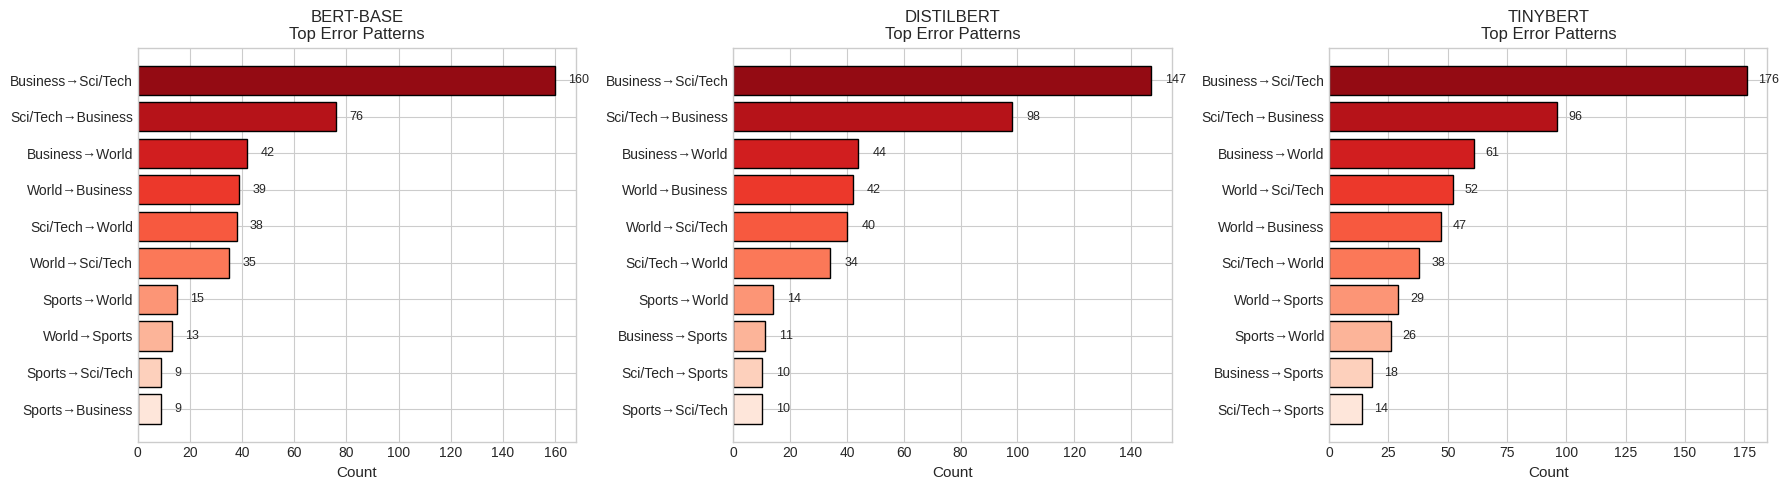

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (model_name, df) in zip(axes, analysis_dfs.items()):
    errors = df[~df['correct']]
    error_counts = errors['error_type'].value_counts().head(10)
    
    colors = sns.color_palette('Reds_r', len(error_counts))
    bars = ax.barh(range(len(error_counts)), error_counts.values, color=colors, edgecolor='black')
    ax.set_yticks(range(len(error_counts)))
    ax.set_yticklabels(error_counts.index)
    ax.set_xlabel('Count', fontsize=11)
    ax.set_title(f'{model_name.upper()}\nTop Error Patterns', fontsize=12)
    ax.invert_yaxis()
    
    for bar, count in zip(bars, error_counts.values):
        ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
               f'{count}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(config.ANALYSIS_DIR, 'error_patterns.png'), dpi=150, bbox_inches='tight')
plt.show()

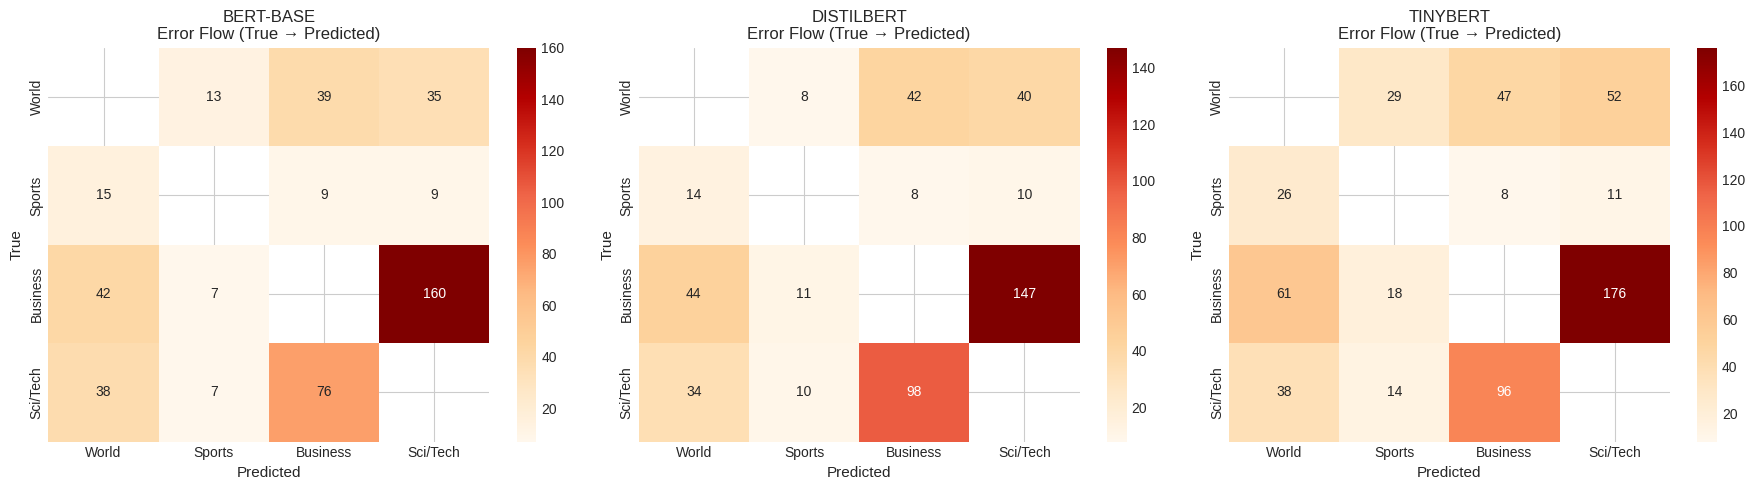

In [10]:
def create_error_flow_matrix(df, label_names):
    """
    Create a matrix showing error flows between classes.
    """
    errors = df[~df['correct']]
    
    flow_matrix = np.zeros((len(label_names), len(label_names)))
    
    for _, row in errors.iterrows():
        flow_matrix[row['true_label'], row['pred_label']] += 1
    
    return flow_matrix

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (model_name, df) in zip(axes, analysis_dfs.items()):
    flow_matrix = create_error_flow_matrix(df, config.LABEL_NAMES)
    
    mask = np.eye(len(config.LABEL_NAMES), dtype=bool)
    
    sns.heatmap(
        flow_matrix,
        annot=True,
        fmt='.0f',
        cmap='OrRd',
        xticklabels=config.LABEL_NAMES,
        yticklabels=config.LABEL_NAMES,
        ax=ax,
        mask=mask
    )
    ax.set_title(f'{model_name.upper()}\nError Flow (True → Predicted)', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('True', fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(config.ANALYSIS_DIR, 'error_flow.png'), dpi=150, bbox_inches='tight')
plt.show()

## 4. Confidence Analysis

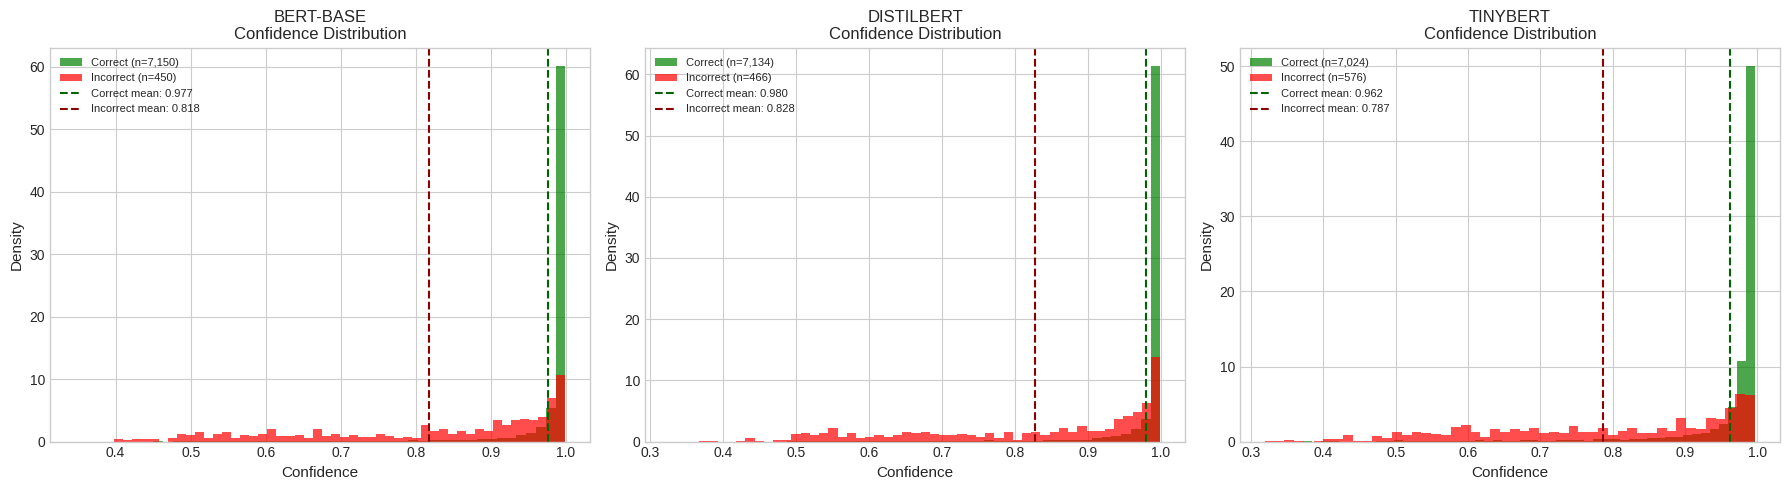

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (model_name, df) in zip(axes, analysis_dfs.items()):
    correct = df[df['correct']]['confidence']
    incorrect = df[~df['correct']]['confidence']
    
    ax.hist(correct, bins=50, alpha=0.7, label=f'Correct (n={len(correct):,})', color='green', density=True)
    ax.hist(incorrect, bins=50, alpha=0.7, label=f'Incorrect (n={len(incorrect):,})', color='red', density=True)
    
    ax.axvline(correct.mean(), color='darkgreen', linestyle='--', label=f'Correct mean: {correct.mean():.3f}')
    ax.axvline(incorrect.mean(), color='darkred', linestyle='--', label=f'Incorrect mean: {incorrect.mean():.3f}')
    
    ax.set_xlabel('Confidence', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'{model_name.upper()}\nConfidence Distribution', fontsize=12)
    ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(config.ANALYSIS_DIR, 'confidence_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

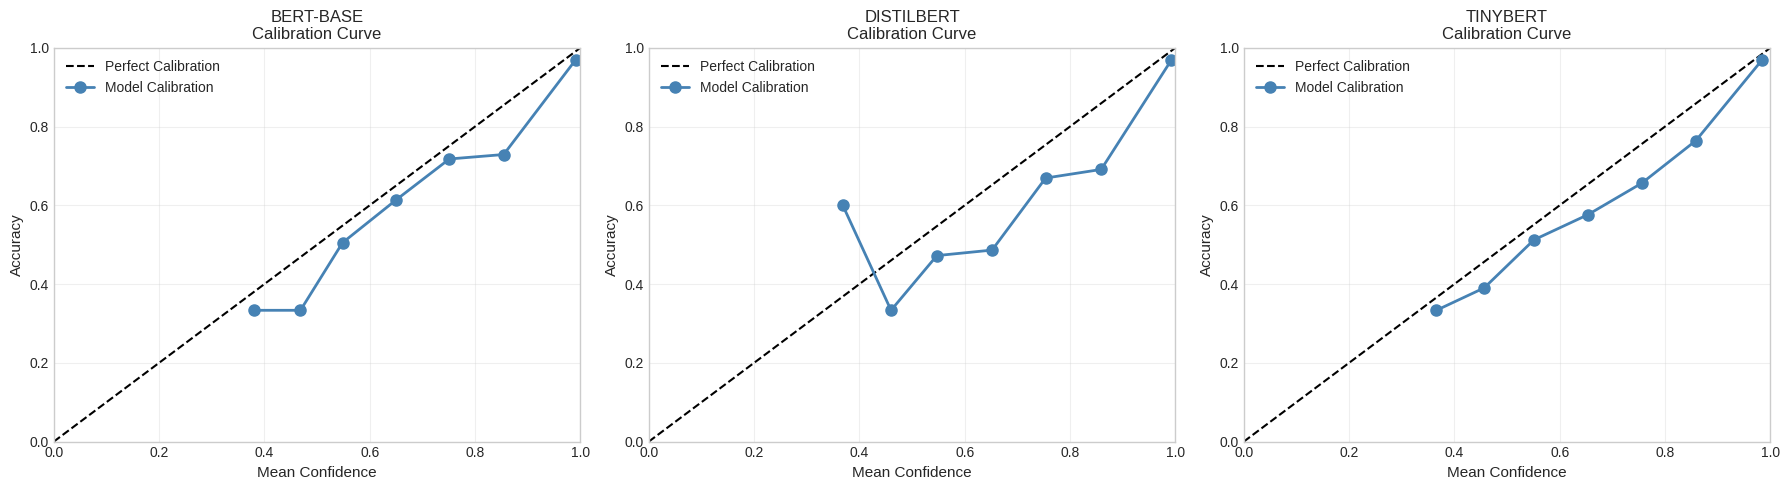

In [12]:
def compute_calibration(df, n_bins=10):
    """
    Compute calibration metrics.
    """
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(df['confidence'], bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    calibration_data = []
    
    for i in range(n_bins):
        mask = bin_indices == i
        if mask.sum() > 0:
            bin_df = df[mask]
            calibration_data.append({
                'bin_center': (bins[i] + bins[i+1]) / 2,
                'mean_confidence': bin_df['confidence'].mean(),
                'accuracy': bin_df['correct'].mean(),
                'count': len(bin_df)
            })
    
    return pd.DataFrame(calibration_data)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (model_name, df) in zip(axes, analysis_dfs.items()):
    cal_df = compute_calibration(df)
    
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    
    ax.plot(cal_df['mean_confidence'], cal_df['accuracy'], 'o-', 
           color='steelblue', linewidth=2, markersize=8, label='Model Calibration')
    
    ax.set_xlabel('Mean Confidence', fontsize=11)
    ax.set_ylabel('Accuracy', fontsize=11)
    ax.set_title(f'{model_name.upper()}\nCalibration Curve', fontsize=12)
    ax.legend()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.ANALYSIS_DIR, 'calibration_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

In [13]:
print("\n🔴 High Confidence Errors Analysis:")
print(f"   (Confidence > {config.CONFIDENCE_THRESHOLD})")
print("="*60)

high_conf_errors = {}

for model_name, df in analysis_dfs.items():
    high_conf = df[(df['confidence'] > config.CONFIDENCE_THRESHOLD) & (~df['correct'])]
    high_conf_errors[model_name] = high_conf
    
    print(f"\n{model_name.upper()}:")
    print(f"   High confidence errors: {len(high_conf)} ({len(high_conf)/len(df)*100:.2f}%)")
    
    if len(high_conf) > 0:
        print(f"   Mean confidence of errors: {high_conf['confidence'].mean():.4f}")
        print(f"   Error patterns:")
        for pattern, count in high_conf['error_type'].value_counts().head(3).items():
            print(f"      {pattern}: {count}")


🔴 High Confidence Errors Analysis:
   (Confidence > 0.9)

BERT-BASE:
   High confidence errors: 211 (2.78%)
   Mean confidence of errors: 0.9626
   Error patterns:
      Business→Sci/Tech: 76
      Sci/Tech→Business: 33
      World→Business: 20

DISTILBERT:
   High confidence errors: 224 (2.95%)
   Mean confidence of errors: 0.9688
   Error patterns:
      Business→Sci/Tech: 74
      Sci/Tech→Business: 38
      World→Business: 25

TINYBERT:
   High confidence errors: 211 (2.78%)
   Mean confidence of errors: 0.9610
   Error patterns:
      Business→Sci/Tech: 64
      Business→World: 29
      Sci/Tech→Business: 26


## 5. Difficult Sample Identification

In [14]:
all_wrong_mask = np.ones(len(results['bert-base']['labels']), dtype=bool)

for model_name, res in results.items():
    model_correct = res['predictions'] == res['labels']
    all_wrong_mask &= ~model_correct

all_wrong_indices = np.where(all_wrong_mask)[0]

print(f"\n🎯 Universally Difficult Samples:")
print(f"   Samples wrong by ALL models: {len(all_wrong_indices)}")
print(f"   Percentage: {len(all_wrong_indices)/len(all_wrong_mask)*100:.2f}%")


🎯 Universally Difficult Samples:
   Samples wrong by ALL models: 310
   Percentage: 4.08%


In [16]:
if len(all_wrong_indices) > 0:
    difficult_samples = []
    
    for idx in all_wrong_indices[:config.TOP_K_ERRORS]:
        sample = {
            'index': int(idx),
            'text': original_dataset['test'][int(idx)]['description'][:300],
            'true_label': config.LABEL_NAMES[int(results['bert-base']['labels'][idx])]
        }
        
        for model_name, res in results.items():
            sample[f'{model_name}_pred'] = config.LABEL_NAMES[int(res['predictions'][idx])]
            sample[f'{model_name}_conf'] = float(res['confidences'][idx])
        
        difficult_samples.append(sample)
    
    print("\n📝 Sample Difficult Cases:")
    print("="*80)
    
    for i, sample in enumerate(difficult_samples[:5]):
        print(f"\n--- Sample {i+1} (Index: {sample['index']}) ---")
        print(f"True Label: {sample['true_label']}")
        print(f"Text: {sample['text']}...")
        print(f"\nPredictions:")
        for model_name in config.MODELS.keys():
            print(f"   {model_name}: {sample[f'{model_name}_pred']} (conf: {sample[f'{model_name}_conf']:.3f})")


📝 Sample Difficult Cases:

--- Sample 1 (Index: 83) ---
True Label: Business
Text: SAN FRANCISCO -- In the latest of a series of product delays, Intel Corp. has postponed the launch of a video display chip it had previously planned to introduce by year end, putting off a showdown with Texas Instruments Inc. in the fast-growing market for high-definition television displays....

Predictions:
   bert-base: Sci/Tech (conf: 0.903)
   distilbert: Sci/Tech (conf: 0.994)
   tinybert: Sci/Tech (conf: 0.969)

--- Sample 2 (Index: 103) ---
True Label: Business
Text: Charly Travers offers advice on withstanding the volatility of the biotech sector....

Predictions:
   bert-base: Sci/Tech (conf: 0.789)
   distilbert: Sci/Tech (conf: 0.828)
   tinybert: Sci/Tech (conf: 0.648)

--- Sample 3 (Index: 110) ---
True Label: Business
Text: Web giant Yahoo! is gambling that price cuts on its domain name registration and Web hosting products will make it more competitive with discounters in the space -- wh

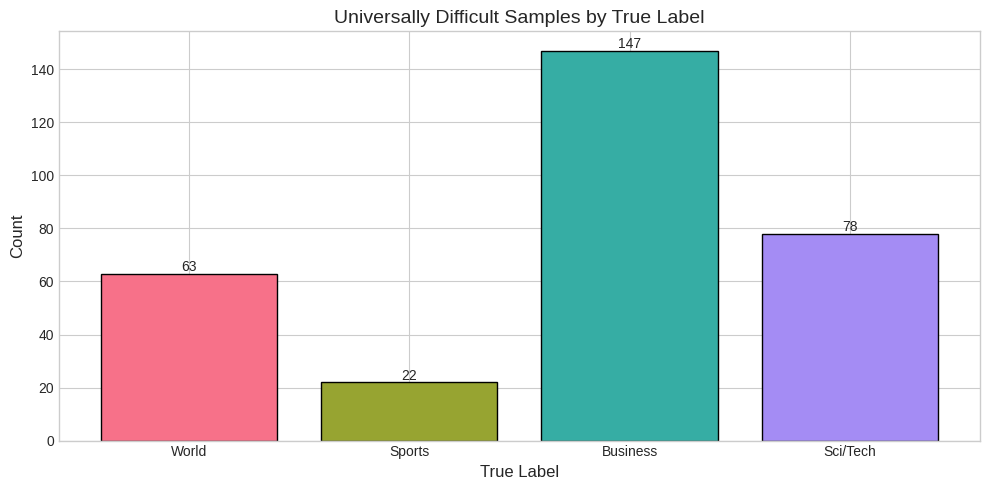

In [17]:
if len(all_wrong_indices) > 0:
    difficult_true_labels = results['bert-base']['labels'][all_wrong_indices]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    label_counts = Counter(difficult_true_labels)
    labels = [config.LABEL_NAMES[i] for i in range(config.NUM_LABELS)]
    counts = [label_counts.get(i, 0) for i in range(config.NUM_LABELS)]
    
    colors = sns.color_palette('husl', config.NUM_LABELS)
    bars = ax.bar(labels, counts, color=colors, edgecolor='black')
    
    ax.set_xlabel('True Label', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Universally Difficult Samples by True Label', fontsize=14)
    
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
               f'{count}', ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.ANALYSIS_DIR, 'difficult_samples_by_label.png'), dpi=150, bbox_inches='tight')
    plt.show()

## 6. Cross-Model Agreement Analysis

In [18]:
model_names = list(config.MODELS.keys())

pred_matrix = np.column_stack([results[m]['predictions'] for m in model_names])

def count_agreement(predictions):
    """Count how many models agree on each prediction."""
    unique, counts = np.unique(predictions, return_counts=True)
    return counts.max()

agreement_levels = np.apply_along_axis(count_agreement, 1, pred_matrix)

print("\n🤝 Cross-Model Agreement Analysis:")
print("="*50)

for level in range(1, len(model_names) + 1):
    count = (agreement_levels == level).sum()
    pct = count / len(agreement_levels) * 100
    print(f"   {level}/{len(model_names)} models agree: {count:,} samples ({pct:.1f}%)")


🤝 Cross-Model Agreement Analysis:
   1/3 models agree: 10 samples (0.1%)
   2/3 models agree: 437 samples (5.8%)
   3/3 models agree: 7,153 samples (94.1%)



📊 Accuracy by Agreement Level:
   1/3 agreement: 0.2000 (n=10)
   2/3 agreement: 0.6362 (n=437)
   3/3 agreement: 0.9604 (n=7,153)


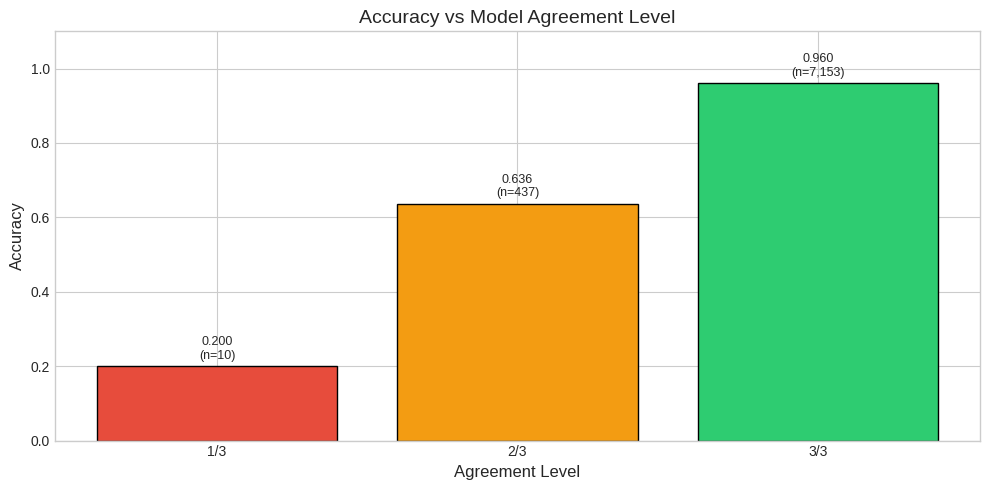

In [19]:
true_labels = results['bert-base']['labels']

print("\n📊 Accuracy by Agreement Level:")
print("="*50)

agreement_accuracy = []
for level in range(1, len(model_names) + 1):
    mask = agreement_levels == level
    if mask.sum() > 0:
        majority_pred = np.apply_along_axis(
            lambda x: Counter(x).most_common(1)[0][0], 1, pred_matrix[mask]
        )
        acc = (majority_pred == true_labels[mask]).mean()
        
        agreement_accuracy.append({
            'Agreement Level': f'{level}/{len(model_names)}',
            'Samples': mask.sum(),
            'Accuracy': acc
        })
        print(f"   {level}/{len(model_names)} agreement: {acc:.4f} (n={mask.sum():,})")

agreement_df = pd.DataFrame(agreement_accuracy)

fig, ax = plt.subplots(figsize=(10, 5))

colors = ['#e74c3c', '#f39c12', '#2ecc71']
bars = ax.bar(agreement_df['Agreement Level'], agreement_df['Accuracy'], color=colors, edgecolor='black')

ax.set_xlabel('Agreement Level', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Accuracy vs Model Agreement Level', fontsize=14)
ax.set_ylim(0, 1.1)

for bar, row in zip(bars, agreement_df.itertuples()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
           f'{row.Accuracy:.3f}\n(n={row.Samples:,})', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(config.ANALYSIS_DIR, 'agreement_accuracy.png'), dpi=150, bbox_inches='tight')
plt.show()


🔄 Pairwise Model Agreement:


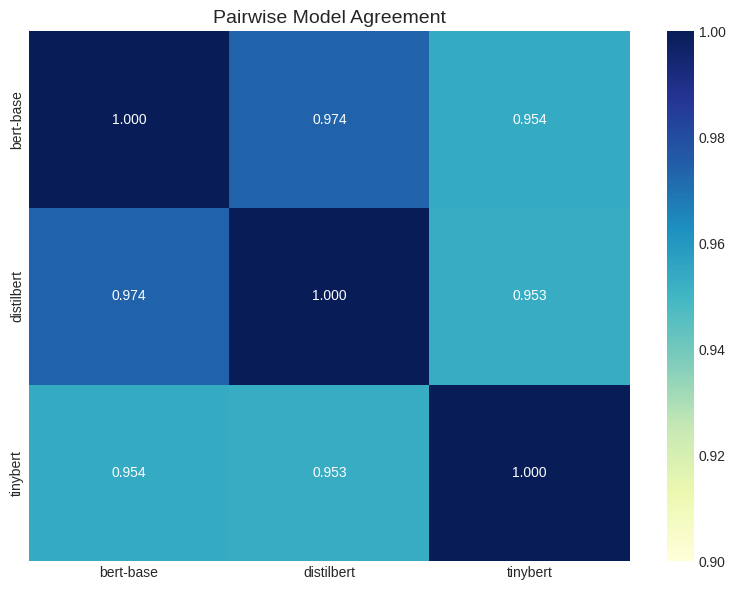

In [20]:
print("\n🔄 Pairwise Model Agreement:")

agreement_matrix = np.zeros((len(model_names), len(model_names)))

for i, m1 in enumerate(model_names):
    for j, m2 in enumerate(model_names):
        agreement = (results[m1]['predictions'] == results[m2]['predictions']).mean()
        agreement_matrix[i, j] = agreement

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    agreement_matrix,
    annot=True,
    fmt='.3f',
    cmap='YlGnBu',
    xticklabels=model_names,
    yticklabels=model_names,
    ax=ax,
    vmin=0.9,
    vmax=1.0
)

ax.set_title('Pairwise Model Agreement', fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(config.ANALYSIS_DIR, 'pairwise_agreement.png'), dpi=150, bbox_inches='tight')
plt.show()

## 7. Qualitative Error Examples

In [22]:
def get_error_examples(model_name, error_type, n_examples=3):
    """
    Get example errors of a specific type.
    """
    df = analysis_dfs[model_name]
    res = results[model_name]
    
    errors = df[df['error_type'] == error_type]
    
    examples = []
    for _, row in errors.head(n_examples).iterrows():
        idx = row['index']
        examples.append({
            'index': idx,
            'text': original_dataset['test'][idx]['description'],
            'true_label': row['true_label_name'],
            'pred_label': row['pred_label_name'],
            'confidence': row['confidence'],
            'probabilities': res['probabilities'][idx]
        })
    
    return examples

best_model = 'bert-base'
df = analysis_dfs[best_model]
errors = df[~df['correct']]
top_errors = errors['error_type'].value_counts().head(3)

print(f"\n📝 Error Examples for {best_model.upper()}:")
print("="*80)

for error_type in top_errors.index:
    print(f"\n🔴 Error Type: {error_type} ({top_errors[error_type]} occurrences)")
    print("-"*70)
    
    examples = get_error_examples(best_model, error_type, n_examples=2)
    
    for i, ex in enumerate(examples):
        print(f"\n   Example {i+1}:")
        print(f"   True: {ex['true_label']} | Predicted: {ex['pred_label']} (conf: {ex['confidence']:.3f})")
        print(f"   Text: {ex['text'][:200]}...")
        print(f"   Class probabilities:")
        for j, label in enumerate(config.LABEL_NAMES):
            print(f"      {label}: {ex['probabilities'][j]:.3f}")


📝 Error Examples for BERT-BASE:

🔴 Error Type: Business→Sci/Tech (160 occurrences)
----------------------------------------------------------------------

   Example 1:
   True: Business | Predicted: Sci/Tech (conf: 0.903)
   Text: SAN FRANCISCO -- In the latest of a series of product delays, Intel Corp. has postponed the launch of a video display chip it had previously planned to introduce by year end, putting off a showdown wi...
   Class probabilities:
      World: 0.000
      Sports: 0.001
      Business: 0.096
      Sci/Tech: 0.903

   Example 2:
   True: Business | Predicted: Sci/Tech (conf: 0.789)
   Text: Charly Travers offers advice on withstanding the volatility of the biotech sector....
   Class probabilities:
      World: 0.056
      Sports: 0.000
      Business: 0.155
      Sci/Tech: 0.789

🔴 Error Type: Sci/Tech→Business (76 occurrences)
----------------------------------------------------------------------

   Example 1:
   True: Sci/Tech | Predicted: Business (conf: 0.

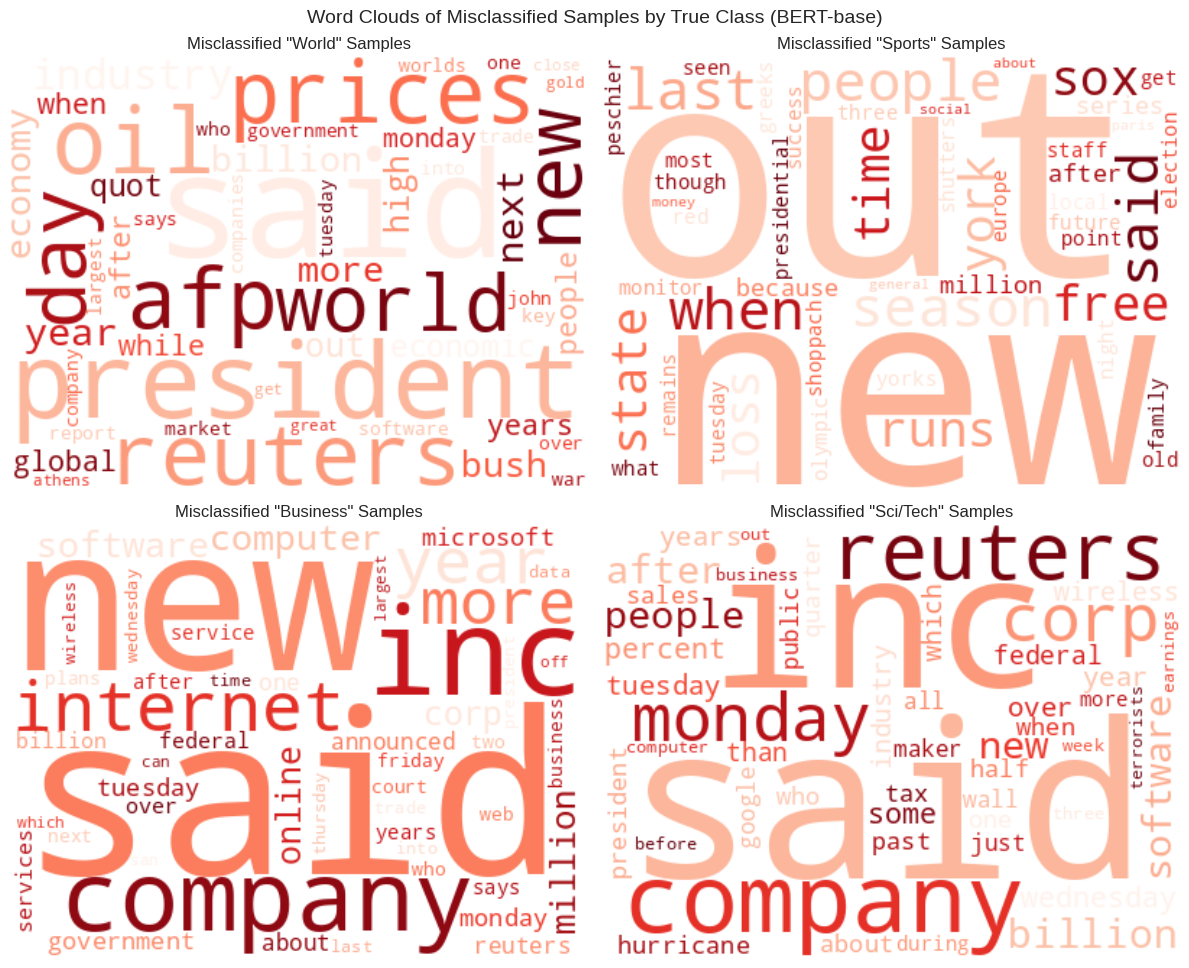

In [24]:
from collections import Counter
import re

def create_error_wordcloud(model_name, true_label_idx):
    """
    Create word cloud for misclassified samples of a specific true class.
    """
    df = analysis_dfs[model_name]
    errors = df[(~df['correct']) & (df['true_label'] == true_label_idx)]
    
    if len(errors) == 0:
        return None
    
    texts = []
    for idx in errors['index']:
        texts.append(original_dataset['test'][idx]['description'])
    
    combined_text = ' '.join(texts)
    
    combined_text = re.sub(r'[^a-zA-Z\s]', '', combined_text.lower())
    
    stop_words = {'the', 'a', 'an', 'in', 'on', 'at', 'to', 'for', 'of', 'and', 'is', 'are', 
                  'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does',
                  'did', 'will', 'would', 'could', 'should', 'may', 'might', 'must', 'that',
                  'this', 'these', 'those', 'it', 'its', 'with', 'as', 'by', 'from', 'or',
                  'but', 'not', 'no', 'so', 'if', 'they', 'their', 'them', 'he', 'she',
                  'his', 'her', 'we', 'our', 'us', 'you', 'your', 'i', 'my', 'me'}
    
    words = [w for w in combined_text.split() if w not in stop_words and len(w) > 2]
    word_freq = Counter(words)
    
    if len(word_freq) == 0:
        return None
    
    wordcloud = WordCloud(
        width=400, height=300,
        background_color='white',
        max_words=50,
        colormap='Reds'
    ).generate_from_frequencies(word_freq)
    
    return wordcloud

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (ax, label) in enumerate(zip(axes, config.LABEL_NAMES)):
    wc = create_error_wordcloud('bert-base', idx)
    if wc:
        ax.imshow(wc, interpolation='bilinear')
        ax.set_title(f'Misclassified "{label}" Samples', fontsize=12)
    else:
        ax.text(0.5, 0.5, 'No errors', ha='center', va='center', fontsize=12)
        ax.set_title(f'"{label}" - No Errors', fontsize=12)
    ax.axis('off')

plt.suptitle('Word Clouds of Misclassified Samples by True Class (BERT-base)', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(config.ANALYSIS_DIR, 'error_wordclouds.png'), dpi=150, bbox_inches='tight')
plt.show()

## 8. Insights & Recommendations

In [25]:
print("\n" + "="*80)
print("📋 KEY INSIGHTS & RECOMMENDATIONS")
print("="*80)

print("\n🎯 1. MODEL PERFORMANCE SUMMARY")
print("-"*50)

for model_name, df in analysis_dfs.items():
    acc = df['correct'].mean()
    errors = df[~df['correct']]
    mean_conf_correct = df[df['correct']]['confidence'].mean()
    mean_conf_error = errors['confidence'].mean() if len(errors) > 0 else 0
    
    print(f"\n   {model_name.upper()}:")
    print(f"   • Accuracy: {acc:.4f}")
    print(f"   • Error rate: {(1-acc)*100:.2f}%")
    print(f"   • Mean confidence (correct): {mean_conf_correct:.4f}")
    print(f"   • Mean confidence (errors): {mean_conf_error:.4f}")
    print(f"   • Confidence gap: {mean_conf_correct - mean_conf_error:.4f}")

print("\n🔴 2. COMMON ERROR PATTERNS")
print("-"*50)

all_errors = []
for model_name, df in analysis_dfs.items():
    errors = df[~df['correct']]
    for error_type in errors['error_type'].unique():
        all_errors.append(error_type)

error_counter = Counter(all_errors)
print("\n   Most common confusion pairs (across all models):")
for error_type, count in error_counter.most_common(5):
    true_class, pred_class = error_type.split('→')
    print(f"   • {true_class} misclassified as {pred_class}: {count} occurrences")

print(f"\n⚠️ 3. DIFFICULT CASES")
print("-"*50)
print(f"\n   • Samples wrong by ALL models: {len(all_wrong_indices)} ({len(all_wrong_indices)/len(true_labels)*100:.2f}%)")
print(f"   • These represent genuinely ambiguous or mislabeled samples")

print(f"\n🤝 4. MODEL AGREEMENT")
print("-"*50)
full_agreement = (agreement_levels == len(model_names)).mean() * 100
print(f"\n   • Full agreement rate: {full_agreement:.1f}%")
print(f"   • Samples with disagreement: {(1 - full_agreement/100)*100:.1f}%")

print(f"\n💡 5. RECOMMENDATIONS")
print("-"*50)
print("""
   Based on the analysis:
   
   A. Model Selection:
      • BERT-base: Best accuracy, recommended for quality-critical applications
      • DistilBERT: Good accuracy/speed trade-off for production
      • TinyBERT: Best for edge deployment or high-throughput scenarios
   
   B. Error Mitigation:
      • Consider ensemble voting for critical predictions
      • Use confidence thresholds to flag uncertain predictions
      • Focus on improving distinction between commonly confused classes
   
   C. Data Quality:
      • Review universally difficult samples for potential labeling issues
      • Consider adding more training examples for confused class pairs
   
   D. Deployment:
      • Implement confidence-based routing for edge cases
      • Monitor error patterns in production
      • Consider human review for low-confidence predictions
""")


📋 KEY INSIGHTS & RECOMMENDATIONS

🎯 1. MODEL PERFORMANCE SUMMARY
--------------------------------------------------

   BERT-BASE:
   • Accuracy: 0.9408
   • Error rate: 5.92%
   • Mean confidence (correct): 0.9768
   • Mean confidence (errors): 0.8181
   • Confidence gap: 0.1587

   DISTILBERT:
   • Accuracy: 0.9387
   • Error rate: 6.13%
   • Mean confidence (correct): 0.9803
   • Mean confidence (errors): 0.8275
   • Confidence gap: 0.1527

   TINYBERT:
   • Accuracy: 0.9242
   • Error rate: 7.58%
   • Mean confidence (correct): 0.9621
   • Mean confidence (errors): 0.7871
   • Confidence gap: 0.1750

🔴 2. COMMON ERROR PATTERNS
--------------------------------------------------

   Most common confusion pairs (across all models):
   • Sci/Tech misclassified as Business: 3 occurrences
   • Sports misclassified as World: 3 occurrences
   • World misclassified as Business: 3 occurrences
   • World misclassified as Sports: 3 occurrences
   • Business misclassified as Sci/Tech: 3 occurr

In [26]:
analysis_report = {
    'dataset': 'AG News',
    'models_analyzed': list(config.MODELS.keys()),
    'total_test_samples': len(true_labels),
    'universally_difficult_samples': len(all_wrong_indices),
    'full_agreement_rate': full_agreement,
    'model_summaries': {},
    'common_error_patterns': dict(error_counter.most_common(10))
}

for model_name, df in analysis_dfs.items():
    analysis_report['model_summaries'][model_name] = {
        'accuracy': float(df['correct'].mean()),
        'error_count': int((~df['correct']).sum()),
        'mean_confidence_correct': float(df[df['correct']]['confidence'].mean()),
        'mean_confidence_error': float(df[~df['correct']]['confidence'].mean()) if (~df['correct']).sum() > 0 else 0,
        'high_confidence_errors': int(((df['confidence'] > config.CONFIDENCE_THRESHOLD) & (~df['correct'])).sum())
    }

report_path = os.path.join(config.ANALYSIS_DIR, 'analysis_report.json')
with open(report_path, 'w') as f:
    json.dump(analysis_report, f, indent=2)

print(f"\n✅ Analysis report saved to: {report_path}")


✅ Analysis report saved to: ./analysis/analysis_report.json
